## Pytorch MNIST 

[Tutorial](https://nextjournal.com/gkoehler/pytorch-mnist) simple CNN torch for MNIST dataset, to simply understand how the whole process of a neural netwoek from scratch works

In a deep learning approach to train a net to solve a specific problem, can be summed up into these steps:

1. Load the data
2. Verify the data is the correct format for the task
3. Augment the data if necessary
4. Decide the correct DNN to use
5. Verify the data is compatible for the net and the task at hand
6. Train the data
7. Verify and Visualize the result

In [1]:
import torch
import torchvision
from pprint import pprint

In [2]:
n_epochs = 10                        # number of times to train over the entire dataset
batch_size_train = 64                # the size of the batch, the bigger, the more space it occupies on the GPU or any device
batch_size_test = 1000               # the batch size test 
learning_rate = 0.001               # lengths of the test in optimization, the bigger, the faster, but also might find a sub-optimal not ideal solution
momentum = 0.5                       # MOmentum: i don't know
log_interval = 10 

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(42)
torch.cuda.is_available()

True

In [3]:
# Getting the patch for the elements

import os 
from pathlib import Path
wd = Path(os.getcwd())

# 1. Load the Data

## Dataloaders

A dataloader is a component used in machine learning pipelines to efficiently load and preprocess data during training. It handles tasks like batching, shuffling, and parallelizing data loading, which are crucial for training models effectively on large datasets. Dataloaders help streamline the process, making it easier to manage and iterate over data, ultimately improving training performance and scalability.

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(os.path.join(wd,'data/'),
                            train=True,
                            download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(os.path.join(wd,'data/'), train=False, download=True,
                             # dataloader are also used to apply simple transformations to the images in input
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# 2. Verify the Dataset

Out task is image classification, so we will need as 

* INput: Image in GreyScale, so an image [1 , 28, 28] -> [ColorChannels, Height, Width ]
* Output: Label of the Image  [1] A simple text 



In [5]:
# Loading the data into the dataloader as in interable, but this is not important right now
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
print("Example of the OUTPUT of Image Classification: \n {}  --> [ColorChannels, Height, Width] \n in the data type: {}".format(example_targets.shape, type(example_targets)))
print("\nExample of the INPUT of Image Classification: \n {}  --> A simple text \n in the data type: {}".format(example_data.shape, type(example_data)))

Example of the OUTPUT of Image Classification: 
 torch.Size([1000])  --> [ColorChannels, Height, Width] 
 in the data type: <class 'torch.Tensor'>

Example of the INPUT of Image Classification: 
 torch.Size([1000, 1, 28, 28])  --> A simple text 
 in the data type: <class 'torch.Tensor'>


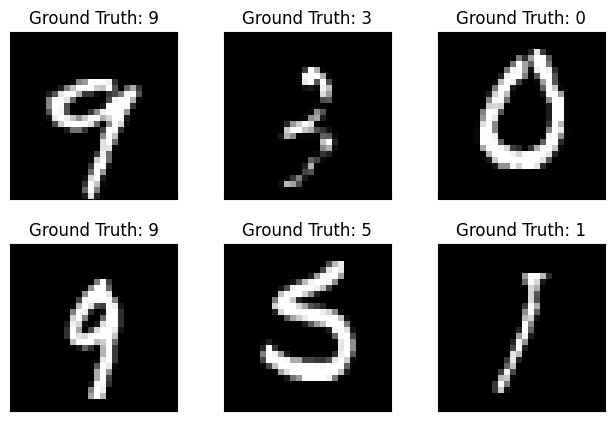

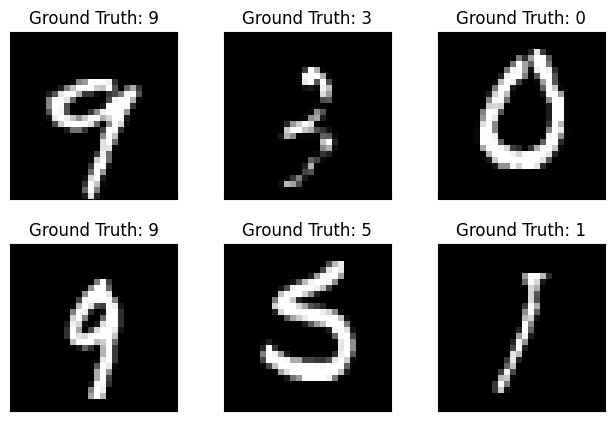

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# 3. DEFINE THE NET

The choice the neural network is really important when you are working with huge datasets. With the MNIST dataset is not really important, but here we are exaplaining easily how a raw dataset can be used

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
#A neural network can defined with a class
class Net(nn.Module):

    # in the init function to defin the layers
    def __init__(self):
        super(Net, self).__init__() # Super, to superimpose the __init__ over the default __init__ in nn.Module
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=0, stride=1)   # Input: [ None, 1, 28, 28]  Output: [ None, 10, 24, 24]
                                                                                                      # There is a MaxPoolLayer -> I: [ None, 10, 24, 24] -> O: [ None, 10, 12, 12]
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0, stride=1)  # Input: [ None, 10, 12, 12]  Output: [ None, 20, 8, 8]
                                                                                                     # # There is a MaxPoolLayer -> I: [ None, 20, 8, 8] -> O: [ None, 20,  4, 4]
        self.conv2_drop = nn.Dropout2d(p=0.4)    # I: [ None, 20, 8, 8] -> O: [ None, 20, 4, 4]
        self.fc1 = nn.Linear(in_features=320, out_features=50)    # Input features: 20*4*4-> 320
        self.fc2 = nn.Linear(in_features=50, out_features=10)
         # out 10 because there are 10 classes at the end

    # a forward funnction to pass the elements the 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.LBFGS(network.parameters(), lr=learning_rate)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), os.path.join(wd,'data/model.pth'))
            torch.save(optimizer.state_dict(), os.path.join(wd,'data/model.pth'))

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_9356/4014770621.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/helldiver/.virtualenvs/ml_scratch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2913, Accuracy: 732/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311504
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.281918
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.283899
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.308684
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.304537
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.278779
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.296085
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.290446
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.278080
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.301561
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.270413
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.299234
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.255259
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.314147
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.276005
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.259090
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.294351
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.270989
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.273465
Train Epoch: 1 [12160/6

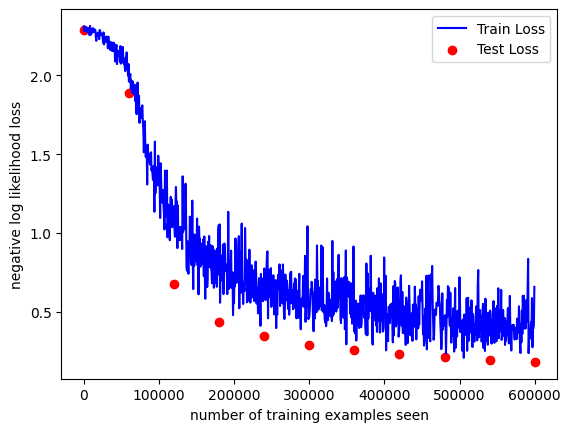

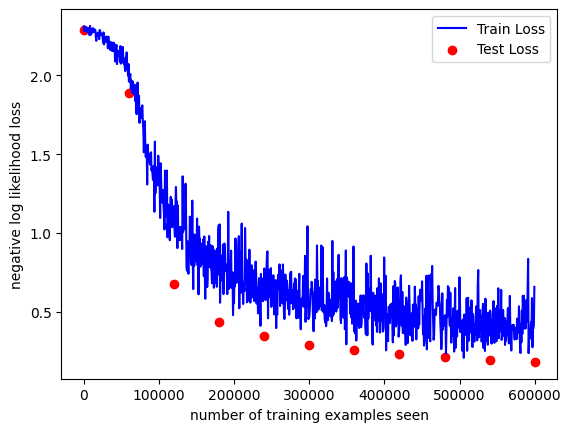

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# Comapre with another model

Now let's see this compared to another model, which is similar in design, but deeper, in the sense that there are more convolutional layers than before. The general idea regarding convolutional layers is: the deeper they are, the more abstract information they can learn. 

If you take as example the [the convolution Example](learn_anything/ComputerVision/Convolution.ipynb), the Convolution operation can understand the opearation that is happening on the image, like a vertical filter and a horizonatl filter. Just in the 1st layer of the following NN, there 10 of these filters. IN Training, the neural netowek will optimize these filters in order to achieve probably and ever deeper and better result. The filters will trasnform the images in an even more abstract way in which we huamns cannot comprehend, but the NN finds it more suited to exaplin the final result. Remember that in the end it is trying to reduce a loss function

IN the following NN there are more than 150 filters in total, which can try to understand even better the images is trying to process. It may lead to a better or worse result, we don't know. Many times Machine Learning is just a holistic science, and you have to make many trials to understand the better architecture and that is why there are so many different fine tuned models out there. 

In [16]:
#A neural network can defined with a class
class Net_v2(nn.Module):

    # in the init function to defin the layers
    def __init__(self):
        super(Net_v2, self).__init__() # Super, to superimpose the __init__ over the default __init__ in nn.Module
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0, stride=1)   # Input: [ None, 1, 28, 28]  Output: [ None, 10, 26, 26]
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0, stride=1)  # Input: [ None, 10, 26, 26]  Output: [ None, 20, 24, 24]
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=0, stride=1)  # Input: [ None, 20, 24, 24]  Output: [ None, 40, 22, 22]
        self.conv4 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=0, stride=1)  # Input: [ None, 40, 22, 22]  Output: [ None, 80, 20, 20]
        self.conv4_drop = nn.Dropout2d(p=0.4)    # Input: [ None, 80, 20, 20]  Output: [ None, 80, 20, 20]
        self.fc1 = nn.Linear(in_features=80*10*10, out_features=250)            
        self.fc2 = nn.Linear(in_features=250, out_features=10)
         # out 10 because the 

    # a forward funnction to pass the elements the 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = x.view(-1, 80*10*10)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [17]:
train_losses_m1 = train_losses
train_counter_m1 = train_counter
test_losses_m1 = test_losses
test_counter_m1 = test_counter
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
network = Net_v2()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.LBFGS(network.parameters(), lr=learning_rate)

In [19]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_9356/2078275990.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3093, Accuracy: 960/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310951
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.313758
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305047
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.294419
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288423
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.279639
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292473
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.277076
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.266601
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.265410
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.264159
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.249900
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.234867
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.244461
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.245632
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.206334
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.207260
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.170645
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.161927
Train Epoch: 1 [12160/

# After mnay interations

After many interations we obtain the following result:
<img src='learn_anything/ComputerVision/images/output.png'>

We can clearly see that a deeper network is able not only to obtain a better result, but also in the long term to understand better the whole dataset and obtain a lower loss value. Note though that the training for the second model, the more complex, took more time compared to the first model. 

Though one might say that a deeper model is better, it is not always the case because it depends on the application of yuor model. Not everywhere it is better to obtain a better and deeper model, sometimes a simpler might just do the trick, but this is for another time. 

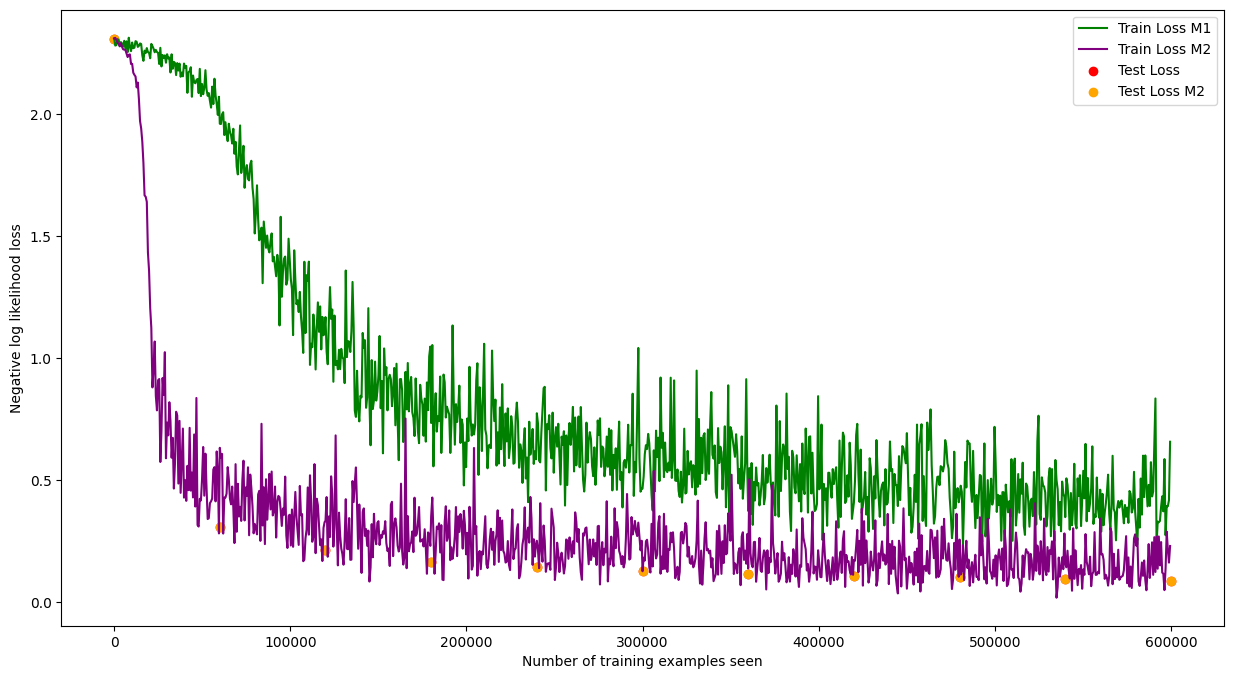

In [21]:
train_losses_m2 = train_losses
train_counter_m2 = train_counter
test_losses_m2 = test_losses
test_counter_m2 = test_counter

fig = plt.figure(figsize=([15,8]))

# Plotting additional train_counter_m1 and train_losses_m1
plt.plot(train_counter_m1, train_losses_m1, color='green')

# Plotting additional train_counter_m2 and train_losses_m2
plt.plot(train_counter_m2, train_losses_m2, color='purple')

# Scatter plot for test_counter and test_losses
plt.scatter(test_counter, test_losses, color='red')

# Scatter plot for test_counter_m2 and test_losses_m2
plt.scatter(test_counter_m2, test_losses_m2, color='orange')

# Adding legend for all plotted lines
plt.legend(['Train Loss M1', 'Train Loss M2', 'Test Loss', 'Test Loss M2'], loc='upper right')

# Labels for x and y axes
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')

# Display the plot
plt.show()
